An ant leaves its anthill in order to forage for food. It moves with the speed of 10cm per second, but it doesn't know where to go, therefore every second it moves randomly 10cm directly north, south, east or west with equal probability.

1. If the food is located on east-west lines 20cm to the north and 20cm to the south, as well as on north-south lines 20cm to the east and 20cm to the west from the anthill, how long will it take the ant to reach it on average?
2. What is the average time the ant will reach food if it is located only on a diagonal line passing through (10cm, 0cm) and (0cm, 10cm) points?
3.Can you write a program that comes up with an estimate of average time to find food for any closed boundary around the anthill? What would be the answer if food is located outside an defined by ( (x – 2.5cm) / 30cm )2 + ( (y – 2.5cm) / 40cm )2 < 1 in coordinate system where the anthill is located at (x = 0cm, y = 0cm)? Provide us with a solution rounded to the nearest integer.



In [1]:
import numpy as np
import scipy.sparse
import scipy.sparse.linalg

In [2]:
from matplotlib import pyplot as plt

### Monte Carlo Estimator

In [3]:
def sample_path(n_mc = 10000, t_max = 100):
    direction = np.random.randint(low=0, high=4, size=(n_mc, t_max))
    dx = 10 * (direction == 0) - 10 * (direction == 2)
    dy = 10 * (direction == 1) - 10 * (direction == 3)
    x = dx.cumsum(axis=1)
    y = dy.cumsum(axis=1)
    return x, y

def reaching_time(x, y, is_on_bound):
    n_mc, t_max = x.shape
    time = 1 + np.sum(np.cumprod(~ is_on_bound(x, y), axis=1), axis=1)
    return time.mean()

### Linear System Solver

In [4]:
def analytical_reaching_time(is_on_bound):
    # Obtain coefficient matrix A by DFS
    neighbors = {}
    def dfs_connected_area(x, y):
        neighbors[x, y] = []
        for x_, y_ in ((x+10, y), (x-10, y), (x, y+10), (x, y-10)):
            if not is_on_bound(x_, y_):
                neighbors[x, y].append((x_, y_))
                if not (x_, y_) in neighbors:
                    dfs_connected_area(x_, y_)
    dfs_connected_area(0, 0)
    
    position_indices = {(x, y): i for i, (x, y) in enumerate(neighbors.keys())}
    x_idx_A = []
    y_idx_A = []
    for x, y in neighbors.keys():
        for x_, y_ in neighbors[x, y]:
            x_idx_A.append(position_indices[x, y])
            y_idx_A.append(position_indices[x_, y_])
    data_A = [1/4 for _ in x_idx_A]
    A = scipy.sparse.csr_matrix((data_A, (x_idx_A, y_idx_A)), dtype=np.float64)
    
    # Solve t = At + 1
    Id = scipy.sparse.identity(A.shape[0])
    ones = np.ones(A.shape[0])
    ts = scipy.sparse.linalg.spsolve(Id - A, ones)
    
    return {(x, y): ts[position_indices[x, y]] for x, y in sorted(neighbors.keys())}

### Question 1

In [5]:
is_on_bound = lambda x, y: np.logical_or(np.abs(x) == 20, np.abs(y) == 20) 

In [9]:
x, y = sample_path()
reaching_time(x, y, is_on_bound)

14.5024

In [7]:
analytical_reaching_time(is_on_bound)

{(-10, -10): 2.75,
 (-10, 0): 3.4999999999999996,
 (-10, 10): 2.7499999999999996,
 (0, -10): 3.5,
 (0, 0): 4.499999999999999,
 (0, 10): 3.499999999999999,
 (10, -10): 2.7499999999999996,
 (10, 0): 3.4999999999999996,
 (10, 10): 2.7499999999999996}

### Question 2

In [8]:
is_on_bound = lambda x, y: x + y == 10
ts = (10 ** np.linspace(1, 3)).astype(int)
t_reach_mc = []
for t in ts:
    x, y = sample_path(t_max=t)
    t_reach_mc.append(reaching_time(x, y, is_on_bound))

Text(0.5, 1.0, 'The MC estimate of the stopping time diverges as we increase the maximum time.')

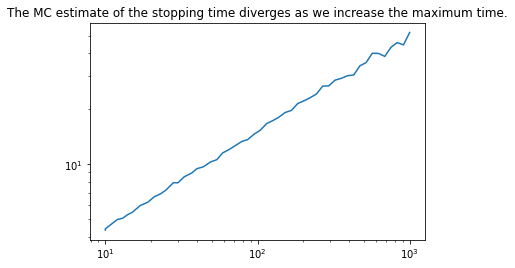

In [10]:
plt.plot(ts, t_reach_mc)
plt.xscale('log')
plt.yscale('log')
plt.title("The MC estimate of the stopping time seems to diverge as we increase the maximum time.")

### Question 3

In [11]:
is_on_bound = lambda x, y:  ((x - 2.5) / 30) ** 2 + ((y - 2.5) / 40) ** 2 > 1

In [12]:
x, y = sample_path()
reaching_time(x, y, is_on_bound)

14.0504

In [14]:
analytical_reaching_time(is_on_bound)

{(-20, -20): 4.897778521585673,
 (-20, -10): 6.875596102062348,
 (-20, 0): 7.478686247937064,
 (-20, 10): 7.017668223507226,
 (-20, 20): 5.102722926452644,
 (-10, -30): 4.65512759082783,
 (-10, -20): 8.715517984280346,
 (-10, -10): 11.125919638726655,
 (-10, 0): 12.021480666178684,
 (-10, 10): 11.4892637196392,
 (-10, 20): 9.393223482303352,
 (-10, 30): 5.418678081536692,
 (0, -30): 5.90499237903097,
 (0, -20): 10.183246185981226,
 (0, -10): 12.891083802385245,
 (0, 0): 13.99205305841182,
 (0, 10): 13.524682506567537,
 (0, 20): 11.562229201584868,
 (0, 30): 8.281488843843416,
 (0, 40): 4.079437716726611,
 (10, -30): 4.781595739314827,
 (10, -20): 9.221390578228338,
 (10, -10): 12.263116326421281,
 (10, 0): 13.53096525851581,
 (10, 10): 13.05518404663426,
 (10, 20): 11.049521973625161,
 (10, 30): 8.065610375525496,
 (10, 40): 4.036262023063027,
 (20, -20): 5.657604061196019,
 (20, -10): 9.40902566655574,
 (20, 0): 10.813507602595873,
 (20, 10): 10.115566447828531,
 (20, 20): 7.515064270